## Setup

Install Tensorflow Compression via `pip`.

In [1]:
import glob
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

#TAC: moved these imports down a few cells
plt.rcParams.update({'font.size': 14})
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-06-07 05:00:20.632996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 05:00:23.065436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../models/')

In [3]:
%load_ext autoreload
%autoreload 2
# TAC: now we can load these modules. !! Uncomment model if using githup clone !!
#from model import train_das_model, make_das_codec
from utils import extract_image_patches, extract_image_patches_fast, prepare_das_dataset, reconstruct_image_from_patches, load_patch_from_file 

# TAC: modified load_patch_from_file and added this to utils.py
from utils import norm_channel

# Load the preprocessed DAS data from the Google Storate

In [4]:
# Set the data for trainning
file_train = sorted(glob.glob('../data/train/*.npz'))
file_test = sorted(glob.glob('../data/test/*.npz'))

# QC Loaded Data

../data/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T14-00-55_p10min.npz


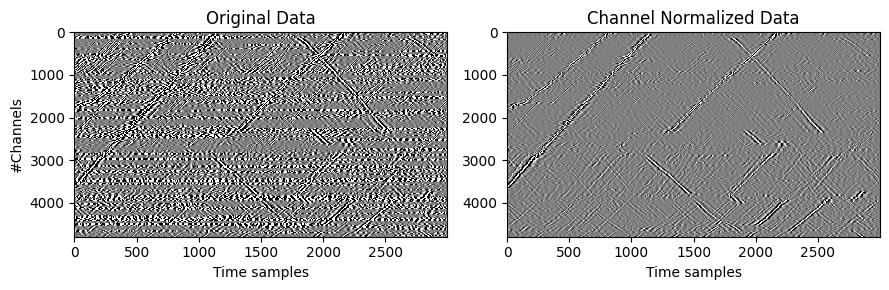

In [5]:
#from patchify import patchify

# Your 2D numpy array
fidx = 5
print(file_train[fidx])
data = np.load(file_train[fidx])['pdata']
#pclip = np.percentile(data, 99.)
pclip = 0.9996
vclip = (1-pclip)*np.abs(data).max()
cn_data = norm_channel(data)
cn_pclip = .99
cn_vclip = (1-cn_pclip)*np.abs(cn_data).max()
#print(f'cn_data.shape: {cn_data.shape}')
#print(f'cn_data:\n{cn_data}')

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2, figsize=(9, 3))  # Adjust the figsize as per your desired size

# Plot orig image
axes[0].imshow(data, cmap='gray', aspect='auto', vmin=-vclip, vmax=vclip)
axes[0].set_title('Original Data')
axes[0].set_xlabel('Time samples')
axes[0].set_ylabel('#Channels')

# Plot chan_norm image
axes[1].imshow(cn_data, cmap='gray', aspect='auto', vmin=-cn_vclip, vmax=cn_vclip)
axes[1].set_title('Channel Normalized Data')
axes[1].set_xlabel('Time samples')
# axes[1].set_ylabel('#Channels')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig('../results/data_preprocessing.png', dpi=300, pad_inches=0.1)
plt.show()


In [6]:
# File 1
muted_channels = [(0, 163), (461, 495)]

# File 2
muted_channels += [(1527+4800, 1630+4800), (1737+4800, 1813+4800), (2551+4800, 2580+4800)]

# File 3
muted_channels += [(2016+4800*2, 2052+4800*2), (3720+4800*2, 3751+4800*2)]

# File 4
muted_channels += [(3090+4800*3, 3220+4800*3)]

# File 5
muted_channels += [(2523+4800*4, 2612+4800*4), (4015+4800*4, 4133+4800*4)]

# File 6
# No changes

# File 7
# No changes

# File 8
muted_channels += [(2371+4800*7, 2372+4800*7), (2391+4800*7, 2394+4800*7),
                   (3351+4800*7, 3354+4800*7), (3424+4800*7, 3426+4800*7),
                   (3462+4800*7, 3465+4800*7)]

# File 9
muted_channels += [(3275+4800*8, 3279+4800*8), (3296+4800*8, 3300+4800*8),
                   (4344+4800*8, 4346+4800*8), (4380+4800*8, 4383+4800*8),
                   (4525+4800*8, 4527+4800*8)]

# File 10
muted_channels += [(4697+4800*9, 4800+4800*9)]

In [7]:
file_train[-10]

'../data/train/train_smcity_sandhill_nc6100_ch0-6100_nt3000_sf5_bp0.08-2.0_D2022-10-02_T19-00-55_p10min.npz'

In [8]:
muted_channels

[(0, 163),
 (461, 495),
 (6327, 6430),
 (6537, 6613),
 (7351, 7380),
 (11616, 11652),
 (13320, 13351),
 (17490, 17620),
 (21723, 21812),
 (23215, 23333),
 (35971, 35972),
 (35991, 35994),
 (36951, 36954),
 (37024, 37026),
 (37062, 37065),
 (41675, 41679),
 (41696, 41700),
 (42744, 42746),
 (42780, 42783),
 (42925, 42927),
 (47897, 48000)]

../data/train/train_smcity_sandhill_nc6100_ch0-6100_nt3000_sf5_bp0.08-2.0_D2022-10-02_T19-00-55_p10min.npz


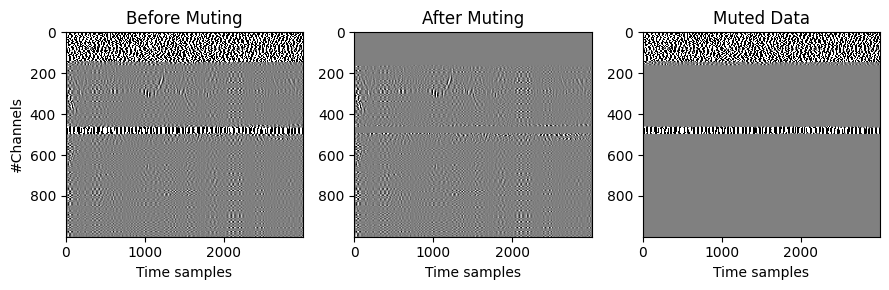

In [9]:
#from patchify import patchify

# Your 2D numpy array
fidx = -10
print(file_train[fidx])
data = np.load(file_train[fidx])['pdata']

data_mute = np.copy(data)
for mute in muted_channels:
    s, e = mute
    s=s-0
    e=e-0
#     print(s,e)
    if s>=0 and e<= 6100:
        data_mute[s:e, :] = 0.0

#pclip = np.percentile(data, 99.)
pclip = 0.9996
vclip = (1-pclip)*np.abs(data[:1000,:]).max()
#print(f'cn_data.shape: {cn_data.shape}')
#print(f'cn_data:\n{cn_data}')

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # Adjust the figsize as per your desired size

# Plot orig image
axes[0].imshow(data[:1000,:], cmap='gray', aspect='auto', vmin=-vclip, vmax=vclip)
axes[0].set_title('Before Muting')
axes[0].set_xlabel('Time samples')
axes[0].set_ylabel('#Channels')

# Plot chan_norm image
axes[1].imshow(data_mute[:1000,:], cmap='gray', aspect='auto', vmin=-vclip, vmax=vclip)
axes[1].set_title('After Muting')
axes[1].set_xlabel('Time samples')
# axes[1].set_ylabel('#Channels')

# Plot chan_norm image
axes[2].imshow(data[:1000,:]-data_mute[:1000,:], cmap='gray', aspect='auto', vmin=-vclip, vmax=vclip)
axes[2].set_title('Muted Data')
axes[2].set_xlabel('Time samples')
# axes[2].set_ylabel('#Channels')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig('../results/data_preprocessing_mute.png', dpi=300, pad_inches=0.1)
plt.show()


## Plot the model

In [10]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


2023-06-07 05:00:46.739455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14587 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


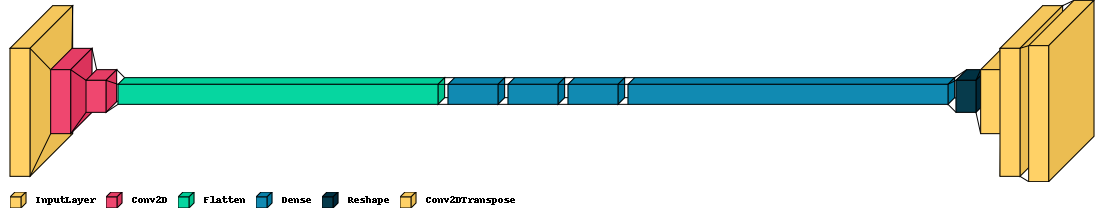

In [11]:
import tensorflow as tf
import visualkeras

latent_dims = 500
patch_size = 32

encoder_input = tf.keras.Input(shape=(patch_size, patch_size, 1), name='img')
x = tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(encoder_input)
x = tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu")(x)
encoder_output = tf.keras.layers.Dense(latent_dims, use_bias=True, activation="leaky_relu")(x)
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')

visualkeras.layered_view(encoder, to_file='encoder.png')

x = tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_3")(encoder_output)
x = tf.keras.layers.Dense(50 * (patch_size//4)**2, use_bias=True, activation="leaky_relu", name="fc_4")(x)
x = tf.keras.layers.Reshape((patch_size//4, patch_size//4, 50))(x)
x = tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(x)
x = tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(x)
decoder_output = tf.keras.layers.Conv2DTranspose(1, 3, activation='relu')(x)
autoencoder = tf.keras.Model(encoder_input, decoder_output, name='autoencoder')

visualkeras.layered_view(autoencoder, legend=True, to_file='autoencoder.png')